<p style="font-size: 36px"><strong>Case Study - Car Market Platform Predictions</strong></p>

by *Julian Dörr*

# Load modules 

In [1]:
from util import plot_describe, ClassifierModule
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import datetime
import csv
from skorch import NeuralNetClassifier, NeuralNetRegressor
from sklearn.linear_model import LogisticRegression, PoissonRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, make_scorer, fbeta_score, mean_absolute_error, mean_squared_error, mean_poisson_deviance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from IPython.display import Markdown as md

# Inspect and clean data

Read data.

In [2]:
df = pd.read_csv(
    './data/AS24_Case_Study_Data.csv', 
    sep=';', 
    parse_dates=['created_date', 'deleted_date'], 
    dayfirst=True,
    date_format='%d.%m.%y'
)

Are there any missings?

In [3]:
df.isnull().sum(axis=0)

article_id                  0
product_tier                0
make_name                   0
price                       0
first_zip_digit             0
first_registration_year     0
created_date                0
deleted_date                0
search_views               10
detail_views               10
stock_days                  0
ctr                        24
dtype: int64

In [4]:
df.loc[df.ctr.isnull() | df.search_views.isnull() | df.detail_views.isnull()]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
6738,355684985,Basic,Volvo,5950,8,2009,2018-08-28,2018-08-28,0.0,0.0,0,NaN
10151,363161664,Basic,Renault,4950,3,2011,2018-11-12,2019-03-01,NaN,NaN,109,NaN
19983,360460901,Basic,Mercedes-Benz,105,7,2004,2018-10-12,2018-10-12,0.0,0.0,-1,NaN
21423,358837372,Basic,Volkswagen,2999,5,2003,2018-09-24,2018-09-24,NaN,NaN,0,NaN
26122,360460897,Basic,Mercedes-Benz,22445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,NaN
27830,358837359,Basic,Volkswagen,2999,5,2003,2018-09-24,2018-09-24,NaN,NaN,0,NaN
28823,360460890,Basic,Mercedes-Benz,26445,7,2011,2018-10-12,2018-10-12,0.0,0.0,0,NaN
38923,360471136,Basic,Audi,1500,2,2012,2018-10-12,2018-10-12,0.0,0.0,0,NaN
43222,360493605,Basic,Mercedes-Benz,37500,3,2002,2018-10-12,2018-10-12,0.0,0.0,0,NaN
47870,358837344,Basic,Volkswagen,2999,5,2003,2018-09-24,2018-09-24,NaN,NaN,0,NaN


There are missing values in `search_views`, `detail_views` and consequently `ctr` for a very small fraction (< 0.1%) of observations of which all belong to the 'Basic' `product_tier` group. Without further information on the decision process which cars are viewed more/less often implementing a reasonable imputation strategy does not add much value (consulting the process-owning business unit would be required first). Moreover, the fraction of missing values is negligible which is why we simply drop the underlying observations (implicit assumption: missing values occur at random).

In [5]:
df = df.loc[~(df.ctr.isnull() | df.search_views.isnull() | df.detail_views.isnull())]

What are the data types?

In [6]:
df.dtypes

article_id                          int64
product_tier                       object
make_name                          object
price                               int64
first_zip_digit                     int64
first_registration_year             int64
created_date               datetime64[ns]
deleted_date               datetime64[ns]
search_views                      float64
detail_views                      float64
stock_days                          int64
ctr                                object
dtype: object

Why is `ctr` read as string? `ctr` is defined as click through rate and calculated as the quotient of detail_views over search_views. The resulting data type should be a float.

In [7]:
df.ctr.value_counts(dropna=False).sort_index(ascending=False)

ctr
9.677.419.354.838.700        1
87.5                         1
8.695.652.173.913.040        1
7.886.435.331.230.280        1
7.574.884.792.626.720        1
                          ... 
0.0007434944237918215        1
0.0006662225183211193        1
0.0004962779156327543        1
0.00045498084291187735       1
0.0                       1244
Name: count, Length: 47246, dtype: int64

Values such as '9.677.419.354.838.700' seem to be a data quality issue. Recalculate `ctr` according to its definition: <br>
$ctr = \frac{detail\_views}{search\_views}$

In [8]:
df['ctr'] = df.detail_views/df.search_views

Let's visually inspect the data to spot potential outliers or other irregularities.

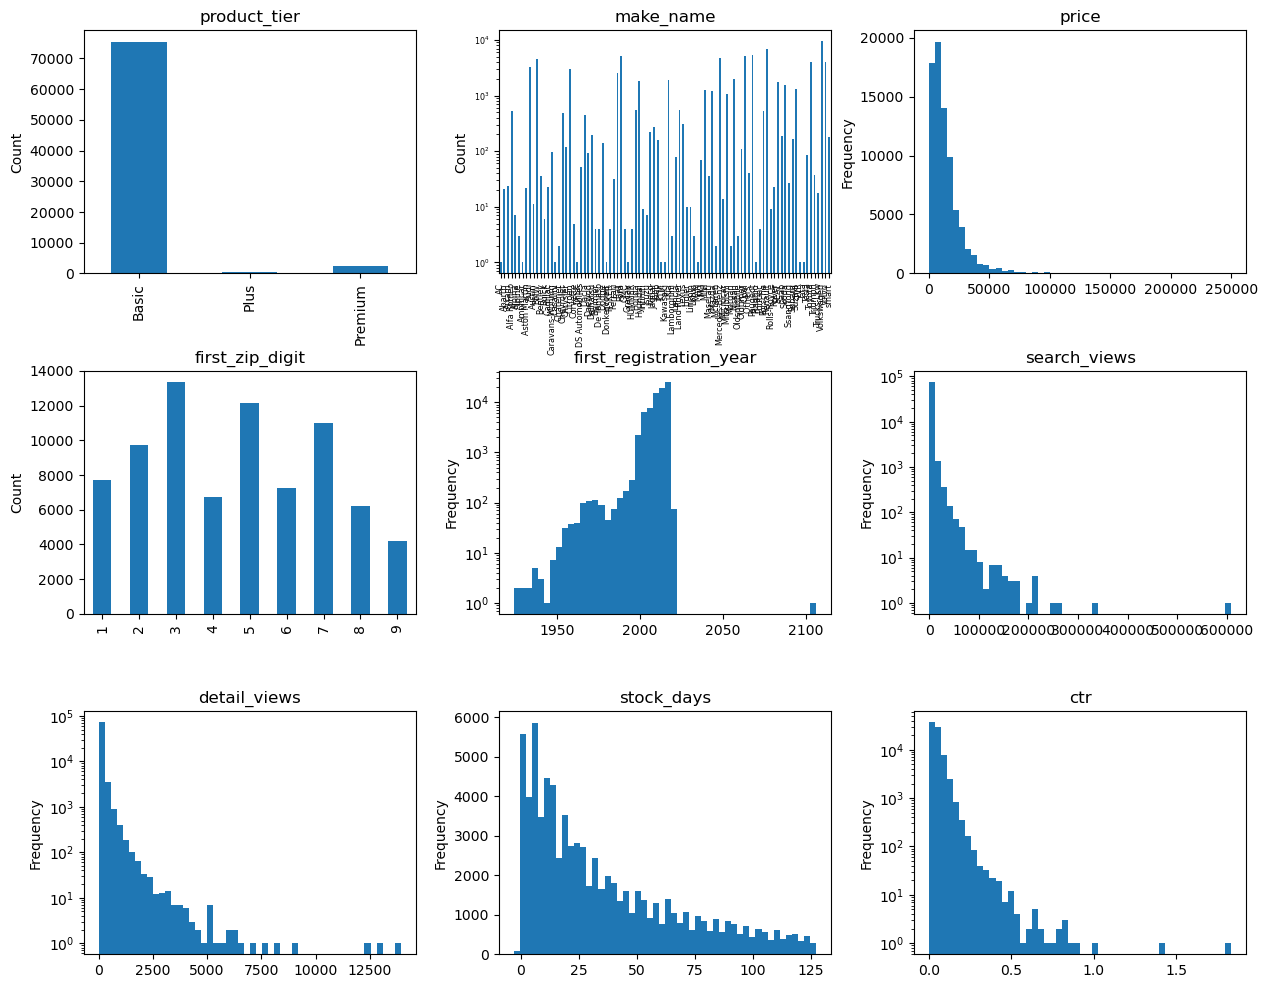

In [9]:
plot_describe(df, columns=df.drop(columns=['article_id', 'created_date', 'deleted_date']).columns, 
              log_dict={
                  'make_name': True,
                  'first_registration_year': True, 
                  'search_views': True, 
                  'detail_views': True,
                  'ctr': True}, size=(15, 12), hspace=0.4, wspace=0.25)

Findings:
- `product_tier` is highly imbalanced. 'Plus' and 'Premium' cars are strongly underrepresented. This will make training of a classification model that is capable to reliably classify the minority groups challenging.
- `first_registration_year` shows one value > 2100 which seems to be a data quality issue. Car registrations in the future make no sense.
- `stock_days` shows at least one value < 0 which seems another data quality issue. Time cannot be negative.
- `search_views`, `detail_views` and consequently `ctr` are strongly skewed to the right with some exceptionally high values.

Drop observation with `first_registration_year` in the future.

In [10]:
df.loc[df.first_registration_year > datetime.date.today().year]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
36302,358877131,Basic,Opel,9250,7,2106,2018-09-24,2018-09-26,113.0,5.0,2,0.044248


In [11]:
df = df.loc[~(df.first_registration_year > datetime.date.today().year)]

Inspect negative values in `stock_days`.

In [12]:
df.loc[df.stock_days<0].sort_values('stock_days').head(3)

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
7465,360447771,Basic,Audi,24850,8,2017,2018-10-12,2018-10-12,17.0,2.0,-3,0.117647
43559,355449450,Basic,Citroen,950,9,2003,2018-08-24,2018-08-24,43.0,0.0,-3,0.000000
28638,362815021,Basic,Volkswagen,11995,3,2013,2018-11-08,2018-11-08,24.0,0.0,-3,0.000000


It seems that `stock_days` does not strictly follow its definition as the time in days between the creation of the listing and the deletion of the listing. Recalculate `ctr` according to its definition: <br>
$stock\_days = deleted\_date - created\_date$

In [13]:
df['stock_days'] = (df.deleted_date - df.created_date).dt.days

The data seems now to be sufficiently clean. So we can proceed with the some feature engineering.

# Feature Engineering

<Axes: >

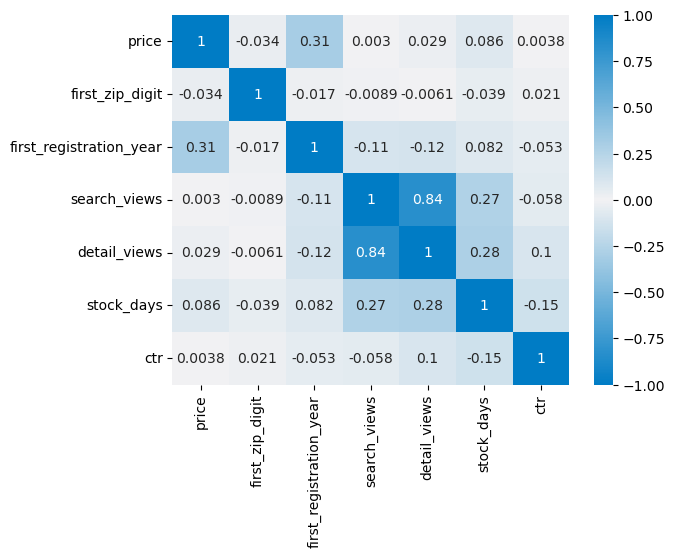

In [14]:
sns.heatmap(df.drop(columns=['article_id', 'product_tier',  'make_name', 'created_date', 'deleted_date']).corr(), vmin=-1, vmax=1, annot=True, cmap=sns.diverging_palette(246, 246, s=100, l=50, as_cmap=True))

Findings:
- Correlations between features seem to be low in most cases
- Third strongest correlation between `stock_days` and `search_views`/`detail_views` which means that the longer a car is listed the more often it is shown/clicked.
- Second strongest (but still modest) correlation between `price` and `first_registration_year` indicating that newer vehicles are typically pricier (ignoring that old timers may be even more pricier). From this observation it makes sense to calculate the vehicle's lifecycle age at the time it was listed on the online platform. This feature is defined as time between the vehicle's first registration and its listing date in years: $lifecycle\_age = created\_date - first\_registration\_year$
- Strongest correlation between `search_views` and `detail_views` which is to be expected. The more often a product is shown to the customer, the more often this product is clicked by the customer. For the second modelling task this observation requires special attention.

Let's calculate the product's lifecyle age which is more verbose than the product's first registration year. Note that for some observations year of first registration is greater than year of listing which results in a negative lifecycle age. I tackle this data quality issue by replacing a negative lifecycle age with zero which seems to be a reasonable strategy.

In [15]:
df['lifecycle_age'] = (df.created_date.dt.year - df.first_registration_year).apply(lambda x: max(x, 0)) 

# Modelling

## Classification model 

**Is it possible to predict the product tier from the information given in the other columns?**

To tackle this question we aim at developing a classification model that allows to predict how likely it is that a product belongs to any of the three product tier categories based on the other product characteristics (features). From a business perspective this seems to be mainly a process automation task, i.e. is it possible to auto-populate the `product_tier` field, once the user provided information on other product characteristics which entail a strong signal on the product's tier.

Let us get a better feeling how the target variable `product_tier` is distributed across the different features.

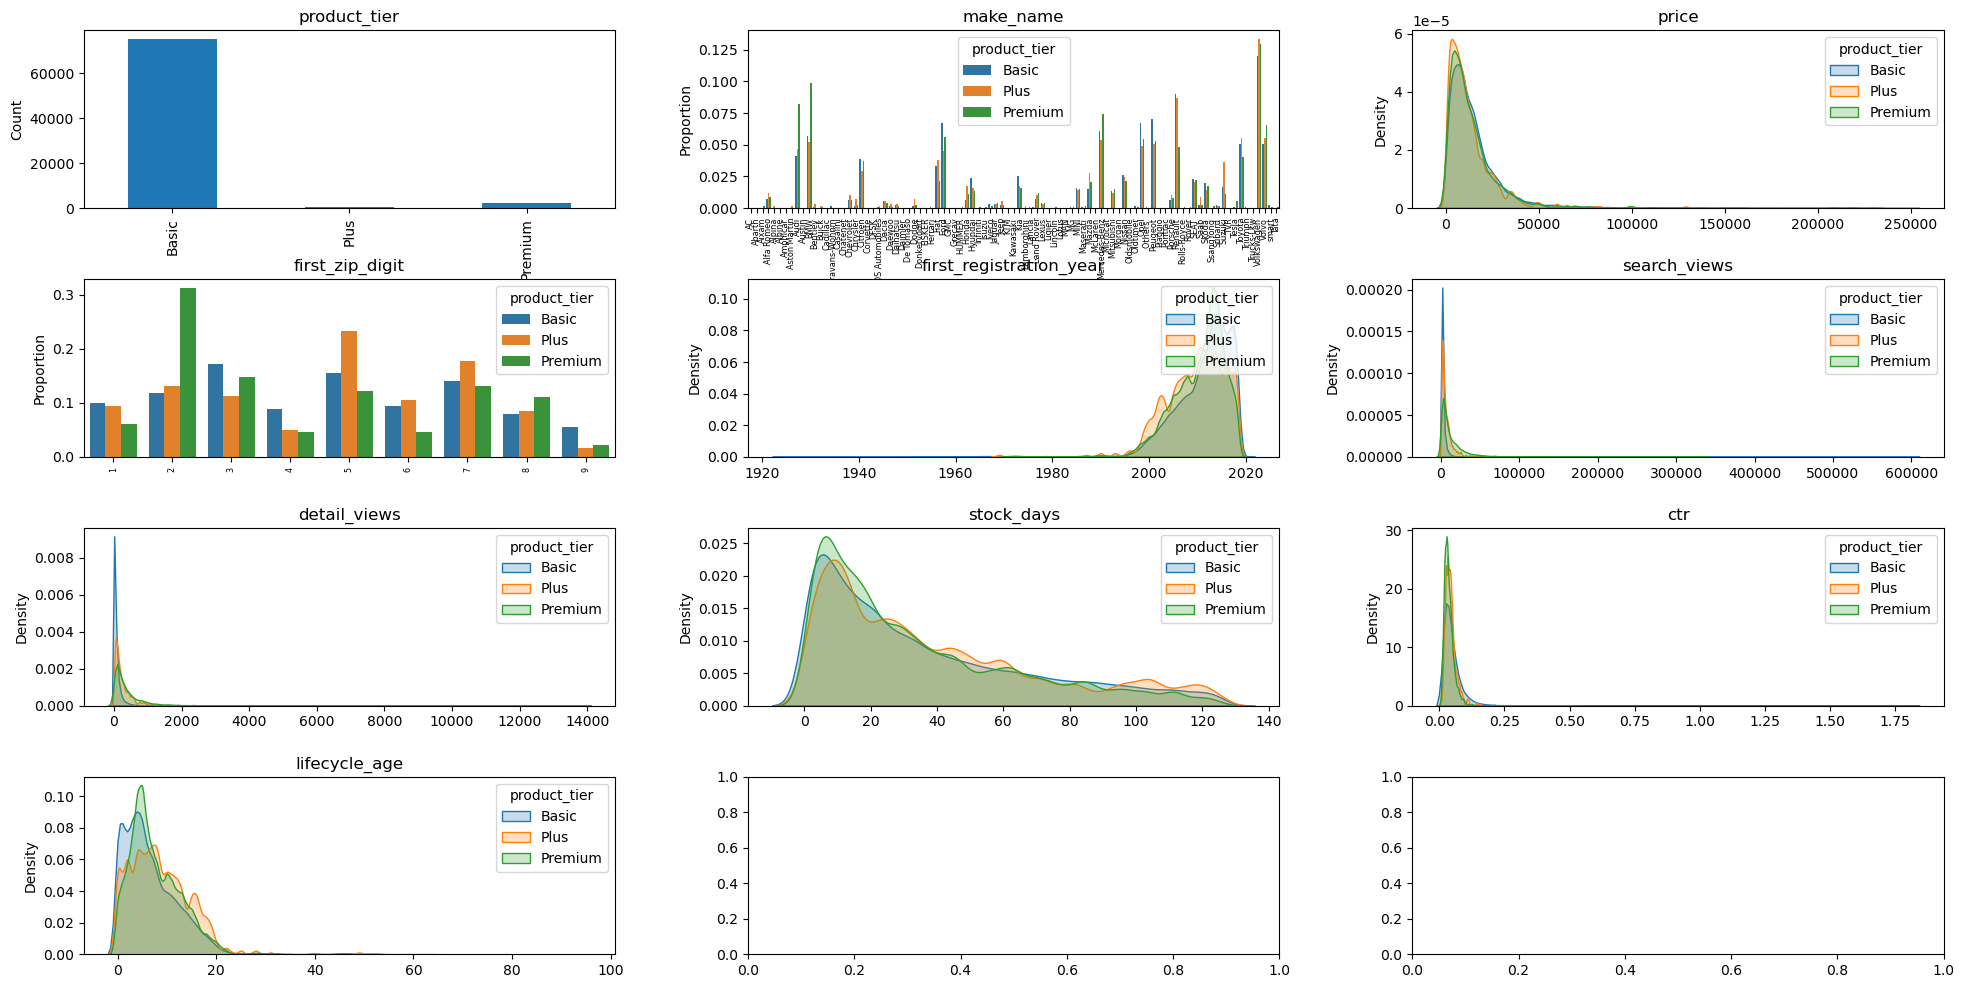

In [300]:
plot_describe(df, columns=df.drop(columns=['article_id', 'created_date', 'deleted_date']).columns, 
              log_dict= {}, hue='product_tier')

Findings:
- 'Premium' products show a relatively high concentration in ZIP codes starting with 2.
- In general, from a pure visual and bivariate inspection it does not seem that the features show a high discriminatory power in distinguishing the three product tier classes because the feature distributions across the three classes look quite similar.
- It cannot be clearly judged whether the car make entails a strong signal in discriminating between the three categories.

To obtain a clearer picture on answering the initial question it requires a multivariate classification model that is developed in the following.

This classifier shall serve the purpose of indicating the probability of a product to belong to any of the three product tier classes. The major challenge will be to train a model that can handle the imbalanced data set. To tackle this issue we try oversampling the minority group in the training data. For this purpose, we use a Synthetic Minority Over-Sampling Technique ([SMOTE](https://arxiv.org/abs/1106.1813)) approach. We also try a undersampling technique using [Tomek Links](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4309452) which helps to remove noisy or hard to classify observations in the majority that do not help the underlying model to find a suitable discrimination boundary. Moreover, we acknowledge that in a use case where `product_tier` field is autopopulated *at the time when the product is listed on the platform*, features that are only generated over the product's listing time will not be available at inference. Therefore, we drop the features `search_views`, `detail_views`, `stock_days` and `ctr` when training the model.

In [301]:
# Features
X = df.drop(columns=['article_id', 'product_tier', 'created_date', 'deleted_date', 'first_registration_year'])
# One-hot encoding of make_name
X = pd.get_dummies(X, columns=['make_name'], drop_first=True, dtype=np.float32) # car make 'AC' serves as reference group
X = X.astype(np.float32)                                                        # create common dtype to ease matrix manipulation

# Target
y = df['product_tier']

In [302]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

In [303]:
# Drop features that are likely not available at inference time
X_train_reduced = X_train.drop(columns=['search_views', 'detail_views', 'stock_days', 'ctr']) # these features are generated over the product's listing period
X_test_reduced = X_test.drop(columns=['search_views', 'detail_views', 'stock_days', 'ctr'])   # these features are generated over the product's listing period

In [304]:
# Oversampling of minority groups via SMOTE
N_majority = y_train.value_counts()['Basic'] # number of observations in the majority group 'Basic'
ratio = 5                                    # for every fifth observation in the majority group there will be one observation in both minority groups

# On original feature set 
X_train_oversampled, y_train_oversampled = SMOTE(
    sampling_strategy={'Plus': round(N_majority/ratio), 'Premium': round(N_majority/ratio)},
    random_state=333).fit_resample(X_train, y_train)

# On reduced feature set
X_train_reduced_oversampled, y_train_reduced_oversampled = SMOTE(
    sampling_strategy={'Plus': round(N_majority/ratio), 'Premium': round(N_majority/ratio)},
    random_state=333).fit_resample(X_train_reduced, y_train)

In [105]:
# Undersampling of majority groups via Tomek Links

# On original feature set 
X_train_undersampled, y_train_undersampled = TomekLinks(
    sampling_strategy='majority'                                   # undersample only the majority class
    ).fit_resample(X_train, y_train)

# On reduced feature set
X_train_reduced_undersampled, y_train_reduced_undersampled = TomekLinks(
    sampling_strategy='majority'                                  # undersample only the majority class
    ).fit_resample(X_train_reduced, y_train)

The target variable in the original training data is highly imbalanced with the following distribution across the `product_tier` categories:

In [106]:
pd.DataFrame(round(y_train.value_counts()/len(y_train), 3)).rename(columns={'count': 'Distribution'})

,Distribution
product_tier,
Basic,0.963
Premium,0.029
Plus,0.008


By oversampling the minority groups 'Plus' and 'Premium' we can create training data that is balanced in its target:

In [107]:
pd.DataFrame(round(y_train_oversampled.value_counts()/len(y_train_oversampled), 3)).rename(columns={'count': 'Distribution'})

,Distribution
product_tier,
Basic,0.714
Plus,0.143
Premium,0.143


By removing observations in the majority class which are closest to the observations from the 'Plus' and 'Premium' class undersampling aims at making it easier for the model to find a suitable discrimination boundary. With this undersampling technique the distribution across the `product_tier` categories looks as follows:

In [108]:
pd.DataFrame(round(y_train_undersampled.value_counts()/len(y_train_undersampled), 3)).rename(columns={'count': 'Distribution'})

,Distribution
product_tier,
Basic,0.962
Premium,0.030
Plus,0.008


In the following, we train five commonly used ML/DL classification models for the purpose of testing whether the product tier can be auto-populated via a predictive model which reliably indicates to which tier a product belongs based on other product features that are typically available at inference. Our setup is as follows:
- for the sake of comparability we train the classifier on the <br>
  (1) original training data (without resampling) <br>
  (2) oversampled training data <br>
  (3) undersampled training data.
- since it is not entirely clear which features are available at inference time for the underlying business case we also train the classifier on the <br>
  (1) original training data (incl. features likely not available at inference) <br>
  (2) reduced training data (excl. features likely not available at inference) <br>
  and we do so for each resampling strategy mentioned above.
- we aim at approximating the best set of hyperparameters on validation sets using cross-validation in order to prevent overfitting.
- we focus on optimizing the average F1-Score for the minority groups. In other words, our goal is to create a classification model that performs well in identifying the maximum number of 'Plus' and 'Premium' vehicles which indeed belong to the 'Plus'/'Premium' class (Recall), while also ensuring that those vehicles classified as 'Plus' or 'Premium' do not actually belong to another product tier class (Precision).
- for scale sensitive models (Support Vector Machine, Neural Network) we scale the features by subtracting their mean and dividing by their standard deviation.

In [309]:
class ClassifierModule(nn.Module):
    """
    Feed-forward neural network classifier module.

    Arguments
    ---------
        num_units : int
            Number of units in the hidden layer (default: 10).
        nonlin : function
            Activation function for the hidden layer (default: F.relu).
        dropout : float
            Dropout probability (default: 0.5).
        output_size : int
            Size of the output layer (default: 3).
    """

    def __init__(self, input_size=97, num_units=10, nonlin=F.relu, dropout=0.5, output_size=3):        
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout
        self.input_size = input_size
        self.output_size = output_size
        

        self.dense0 = nn.Linear(input_size, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, output_size)

    def forward(self, X, **kwargs):
        """
        Forward pass of the neural network.

        Arguments
        ---------
            X : torch.Tensor
                Input tensor.

        Returns
        -------
            y : torch.Tensor
                Output tensor.
        """
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        y = F.softmax(self.output(X), dim=-1)
        return y

In [310]:
NNClassifier = NeuralNetClassifier(
    module=ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device='cuda',       # I have a GeForce RTX 3050 GPU on my local machine which I use for the neural network training
    train_split=False,   # disable the skorch-internal train-validation split as GridSearchCV conducts the train-validation splits
    verbose=0,           # Verbosity is steered via GridSearchCV
)

In [311]:
# Define scoring metric
fscore_tier = make_scorer(
    score_func=fbeta_score, 
    beta=1,                      # equal weight on Precision and Recall
    #labels=['Plus', 'Premium'], # focus on prediction quality of minority groups
    average='macro'              # calculate metrics for each label listed in labels argument, and find their average weighted by support
    )       

# Define the pipeline for each model
pipelines = [
    ('logistic_regression', Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(                               # handles multiclass problem inherently with multi_class='multinomial'
            max_iter=600,
            multi_class='multinomial',
            solver='lbfgs'))                 
    ])),
    ('random_forest', Pipeline([
        ('model', RandomForestClassifier(random_state=333))         # handles multiclass problem inherently
    ])),
    ('gradient_boosting', Pipeline([
        ('model', GradientBoostingClassifier(random_state=333))     # handles multiclass problem as one-vs-the-rest
    ])),
    ('support_vector_machine', Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(random_state=333))                            # handles multiclass problem as one-vs-one
    ])),
    ('neural_network', Pipeline([
        ('scaler', StandardScaler()),
        ('model', NNClassifier)
    ]))
]

# Define the hyperparameter grid for each model
hyperparameters = {
    'logistic_regression': { 
        'model__penalty': [None, 'l2'],
    },
    'random_forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 2, 5],
        'model__min_samples_leaf': [1, 2, 5]
    },
    'gradient_boosting': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0,1, 0.5],
        'model__max_depth': [2, 3, 4]
    },
    'support_vector_machine': {
        'model__C': [0.1, 1, 10],
        #'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
        'model__kernel': ['rbf']
    },
    'neural_network': {
        'model__lr': [0.05, 0.1],
        'model__module__num_units': [10, 20],
        'model__module__dropout': [0, 0.5],
    },
}

Train the models given the different hyperparameter constellations and store the average F1-Score on the validation folds for later comparison.

In [312]:
now = datetime.datetime.now().strftime("%d-%m-%y_%H%M%S")
with open(f'df_model_classification_{now}.csv', 'w') as csvFile:
    fieldnames = ['MODEL', 'SAMPLING', 'PARAMS', 'MEAN_SCORE']
    writer = csv.DictWriter(csvFile, fieldnames=fieldnames)
    writer.writeheader()
    for model_name, pipeline in tqdm([pipelines[4]]):
        if model_name=='neural_network':
            n_jobs=None
        else:
            n_jobs=-1
        for strategy, (X, y) in [#('No resampling (all features)', (X_train, y_train)), 
                                 #('No resampling (inference features)', (X_train_reduced, y_train)), 
                                 ('Oversampling (all features)', (X_train_oversampled, y_train_oversampled)),
                                 ('Oversampling (inference features)', (X_train_reduced_oversampled, y_train_reduced_oversampled)),
                                 #('Undersampling (all features)', (X_train_undersampled, y_train_undersampled)),
                                 #('Undersampling (inference features)', (X_train_reduced_undersampled, y_train_reduced_undersampled)),
                                 ]:
            grid_search = GridSearchCV(pipeline, hyperparameters.get(model_name), cv=3, scoring=fscore_tier, verbose=2, n_jobs=n_jobs)
            if model_name=='neural_network':
                X = X.to_numpy()
                # Handle the case where only the reduced features are used by padding X with zeros
                # Check the second dimension of X
                second_dim = X.shape[1]
                # Check if the second dimension is smaller than original feature space
                if second_dim < 97:
                    # Calculate the number of zeros to add
                    num_zeros = 97 - second_dim
                    # Pad X with zeros along the second dimension
                    X = np.pad(X, ((0, 0), (0, num_zeros)), mode='constant')
                
                y = pd.factorize(y)[0]
                
            grid_search.fit(X, y)
            score = grid_search.cv_results_['mean_test_score']
            params = grid_search.cv_results_['params']
            for i in range(score.shape[0]):
                writer.writerow({
                'MODEL': model_name, 
                'SAMPLING': strategy,
                'PARAMS': params[i], 
                'MEAN_SCORE': score[i]    
                })
                csvFile.flush()

  0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__lr=0.05, model__module__dropout=0, model__module__num_units=10; total time=  16.6s
[CV] END model__lr=0.05, model__module__dropout=0, model__module__num_units=10; total time=  16.5s
[CV] END model__lr=0.05, model__module__dropout=0, model__module__num_units=10; total time=  17.7s
[CV] END model__lr=0.05, model__module__dropout=0, model__module__num_units=20; total time=  17.2s
[CV] END model__lr=0.05, model__module__dropout=0, model__module__num_units=20; total time=  17.4s
[CV] END model__lr=0.05, model__module__dropout=0, model__module__num_units=20; total time=  16.4s
[CV] END model__lr=0.05, model__module__dropout=0.5, model__module__num_units=10; total time=  16.7s
[CV] END model__lr=0.05, model__module__dropout=0.5, model__module__num_units=10; total time=  16.6s
[CV] END model__lr=0.05, model__module__dropout=0.5, model__module__num_units=10; total time=  16.5s
[CV] END model__lr=0.05, model__module__dro

100%|█████████████████████████████████████████████████████████████████████████| 1/1 [15:17<00:00, 917.86s/it]


In [112]:
df_model = pd.read_csv('df_model_29-04-24_175731.csv')

For each model look at the best performing specification on the original validation sets and the oversampled validation sets.

In [116]:
df_model.sort_values('MEAN_SCORE', ascending=False).groupby(['MODEL', 'SAMPLING']).head(1).sort_values(['MODEL', 'MEAN_SCORE'], ascending=False).style

,MODEL,SAMPLING,PARAMS,MEAN_SCORE
398,support_vector_machine,Oversampling (all features),"{'model__C': 10, 'model__kernel': 'rbf'}",0.832224
401,support_vector_machine,Oversampling (inference features),"{'model__C': 10, 'model__kernel': 'rbf'}",0.728257
404,support_vector_machine,Undersampling (all features),"{'model__C': 10, 'model__kernel': 'rbf'}",0.478121
392,support_vector_machine,No resampling (all features),"{'model__C': 10, 'model__kernel': 'rbf'}",0.455249
393,support_vector_machine,No resampling (inference features),"{'model__C': 0.1, 'model__kernel': 'rbf'}",0.327063
405,support_vector_machine,Undersampling (inference features),"{'model__C': 0.1, 'model__kernel': 'rbf'}",0.326982
68,random_forest,Oversampling (all features),"{'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 300}",0.953237
95,random_forest,Oversampling (inference features),"{'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 300}",0.898205
122,random_forest,Undersampling (all features),"{'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 300}",0.491554
14,random_forest,No resampling (all features),"{'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 300}",0.475950


In [120]:
md(f"""The best performing model is a {df_model.sort_values('MEAN_SCORE', ascending=False).iloc[0].MODEL} 
with an average F1-Score of {round(df_model.sort_values('MEAN_SCORE', ascending=False).iloc[0].MEAN_SCORE*100,2)}% 
on the validation folds. Little surprisingly, oversampling strongly helps the model to learn from the minority group 
since for all models the performance is best when being trained on the oversampled training data. 
Moreover, and also expected, the model performs better when being exposed to the entire feature set.
The crucial question is how well the best performing model performs when being confronted with the real-world distribution of the target variable. 
For this purpose, we test the best model's performance on the test set. We do so by using the entire feature set
assuming that if the model does not generalize well on all features it will also not generalize on the reduced inference features.""")

The best performing model is a random_forest 
with an average F1-Score of 95.32% 
on the validation folds. Little surprisingly, oversampling strongly helps the model to learn from the minority group 
since for all models the performance is best when being trained on the oversampled training data. 
Moreover, and also expected, the model performs better when being exposed to the entire feature set.
The crucial question is how well the best performing model performs when being confronted with the real-world distribution of the target variable. 
For this purpose, we test the best model's performance on the test set. We do so by using the entire feature set
assuming that if the model does not generalize well on all features it will also not generalize on the reduced inference features.

In [121]:
# Define the best performing model
pipeline = Pipeline(steps=[
    ('best_model', RandomForestClassifier(max_depth=None, min_samples_leaf=1, n_estimators=300, n_jobs=-1))
])

# Train on the entire oversampled training data
pipeline.fit(X_train_oversampled, y_train_oversampled)

# Make predictions for the test observations
y_pred = pipeline.predict(X_test)

# Return performance metrics
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

       Basic       0.98      1.00      0.99     15073
        Plus       0.08      0.01      0.02       105
     Premium       0.74      0.45      0.56       482

    accuracy                           0.97     15660
   macro avg       0.60      0.48      0.52     15660
weighted avg       0.96      0.97      0.97     15660



We can see that the best performing model does not generalize well:
- from the 105 'Plus'|482 'Premium' products in the test data only 1|216 have been detected by the classifier (Recall = 1/105 = 0.01 | 216/482 = 0.45)
- for 12 vehicles in the test data the classifier has predicted that they are 'Plus' products. Only 1 of them is indeed a 'Plus' article (Precision = 1/12 = 0.08)

**This means that when the classifier is confronted with the real distribution of the target variable it does not help in reliably differentiating between 'Basic', 'Premium' and 'Plus' articles.**

These results come with many caveats:
- zero knowledge about the actual business case, i.e. no exchange with business unit, no information on the meaning/logic of different product tier classes
- limited knowledge about the features and about which features from a process perspective are available at inference
- results derived under time constraints

In a real-world scenario I would undergo the following next steps:
- get in close exchange with business unit trying to better understand the actual use case and the meaning/logic of the target variable `product_tier`
- gather additional observations and/or features if possible
- spend more time on understanding/engineering features
- implement further approaches to handle imbalanced data

## Regression Model

**Is it possible to predict detail views from the information given in the other columns?**

To tackle this question we aim at developing a regression model that allows to predict how often a product's detail views are clicked by users based on other product characteristics and possibly information on underlying advertising campaigns. In the correlation heatmap above we have seen that `search_views` and `detail_views` are strongly positively correlated, i.e. the more often a product is shown to users the more often users click on the product. This is little surprising and means that `search_views` would be a strong predictor for `detail_views` if a model was trained on all other columns including `search_views`. From a business perspective it seems to be a more relevant use case to predict the number of times a product is clicked *normalized* by the number of times it is suggested to the customer, i.e. the click through rate `ctr`. Predicting click through rates instead of the number of detail views can be interesting for several reasons:
- Optimizing advertising campaigns: By identifying which ads or ad appearances are more likely to generate higher click-through rates, businesses can allocate their advertising budget accordingly. This helps in maximizing the effectiveness of advertising efforts.
- Improving user engagement: Pairing product information with user demographics, predicting click-through rates may provide insights into user engagement with products or services. By predicting click-through rates, businesses can identify product but also customer characteristics that influence user behavior and tailor their offerings to better meet user needs and user engagement.
- Measuring campaign performance: Predicting click-through rates allows businesses to measure the performance of their marketing campaigns. By comparing predicted click-through rates with actual click-through rates, it is possible to evaluate the effectiveness of a campaign.

Let us get a better feeling how the target variable `detail_views` is distributed across the different features. For this purpose we categorize the target variable.

In [16]:
df['detail_views_cat'] = pd.cut(df['detail_views'], bins=[0, 50, 100, 20000], include_lowest=True).astype(str)

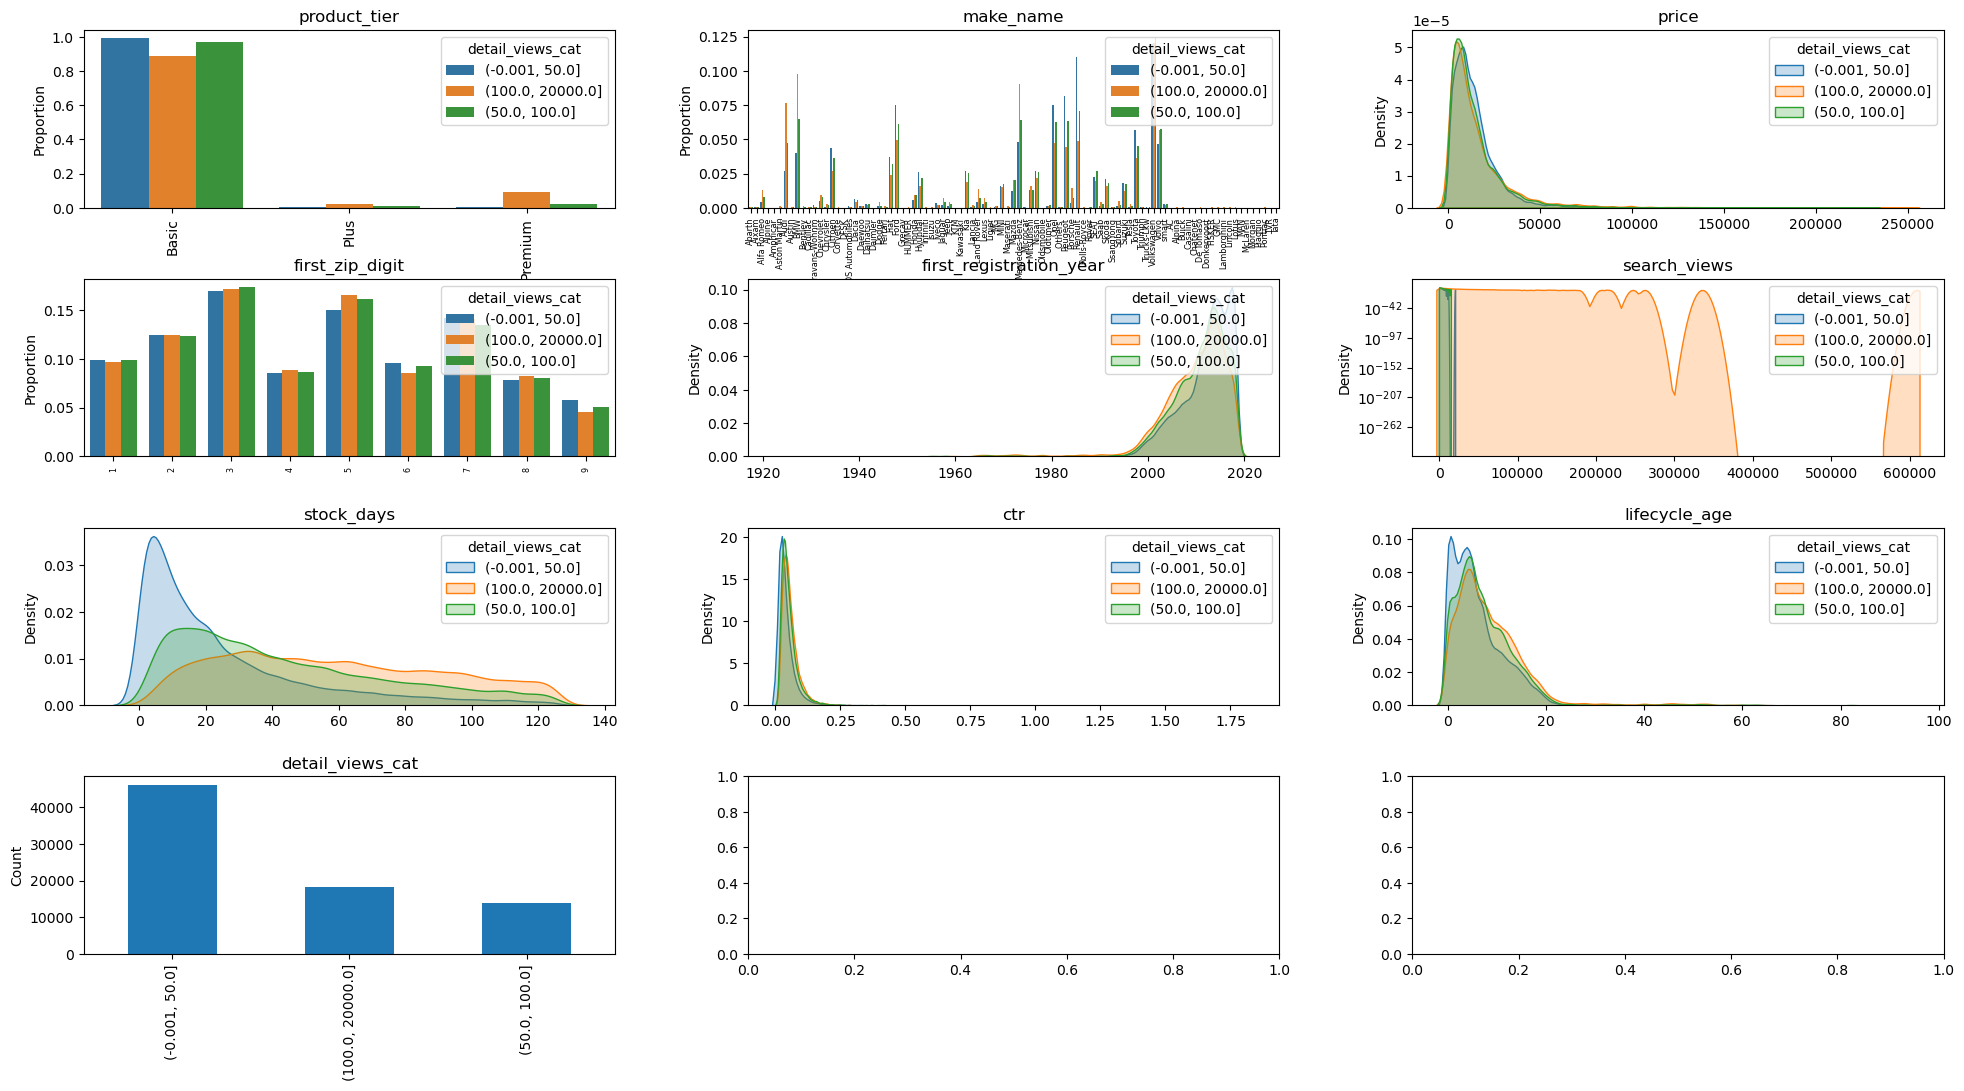

In [17]:
plot_describe(df, df.drop(columns=['article_id', 'created_date', 'deleted_date', 'detail_views']).columns, log_dict={'search_views': True},
              hue='detail_views_cat')

Findings:
- As expected `search_views` but also `stock_days` seem to entail strong discriminatory power for predicting the number of times a product is clicked by the customer. Generally speaking, the longer the product is listed on the platform and the more heavily it is promoted, the more often it will be clicked.


Let's create the same visualization for `ctr`.

In [18]:
df['ctr_cat'] = pd.cut(df['ctr'], bins=[0, 0.04, 0.07, 2], include_lowest=True).astype(str)

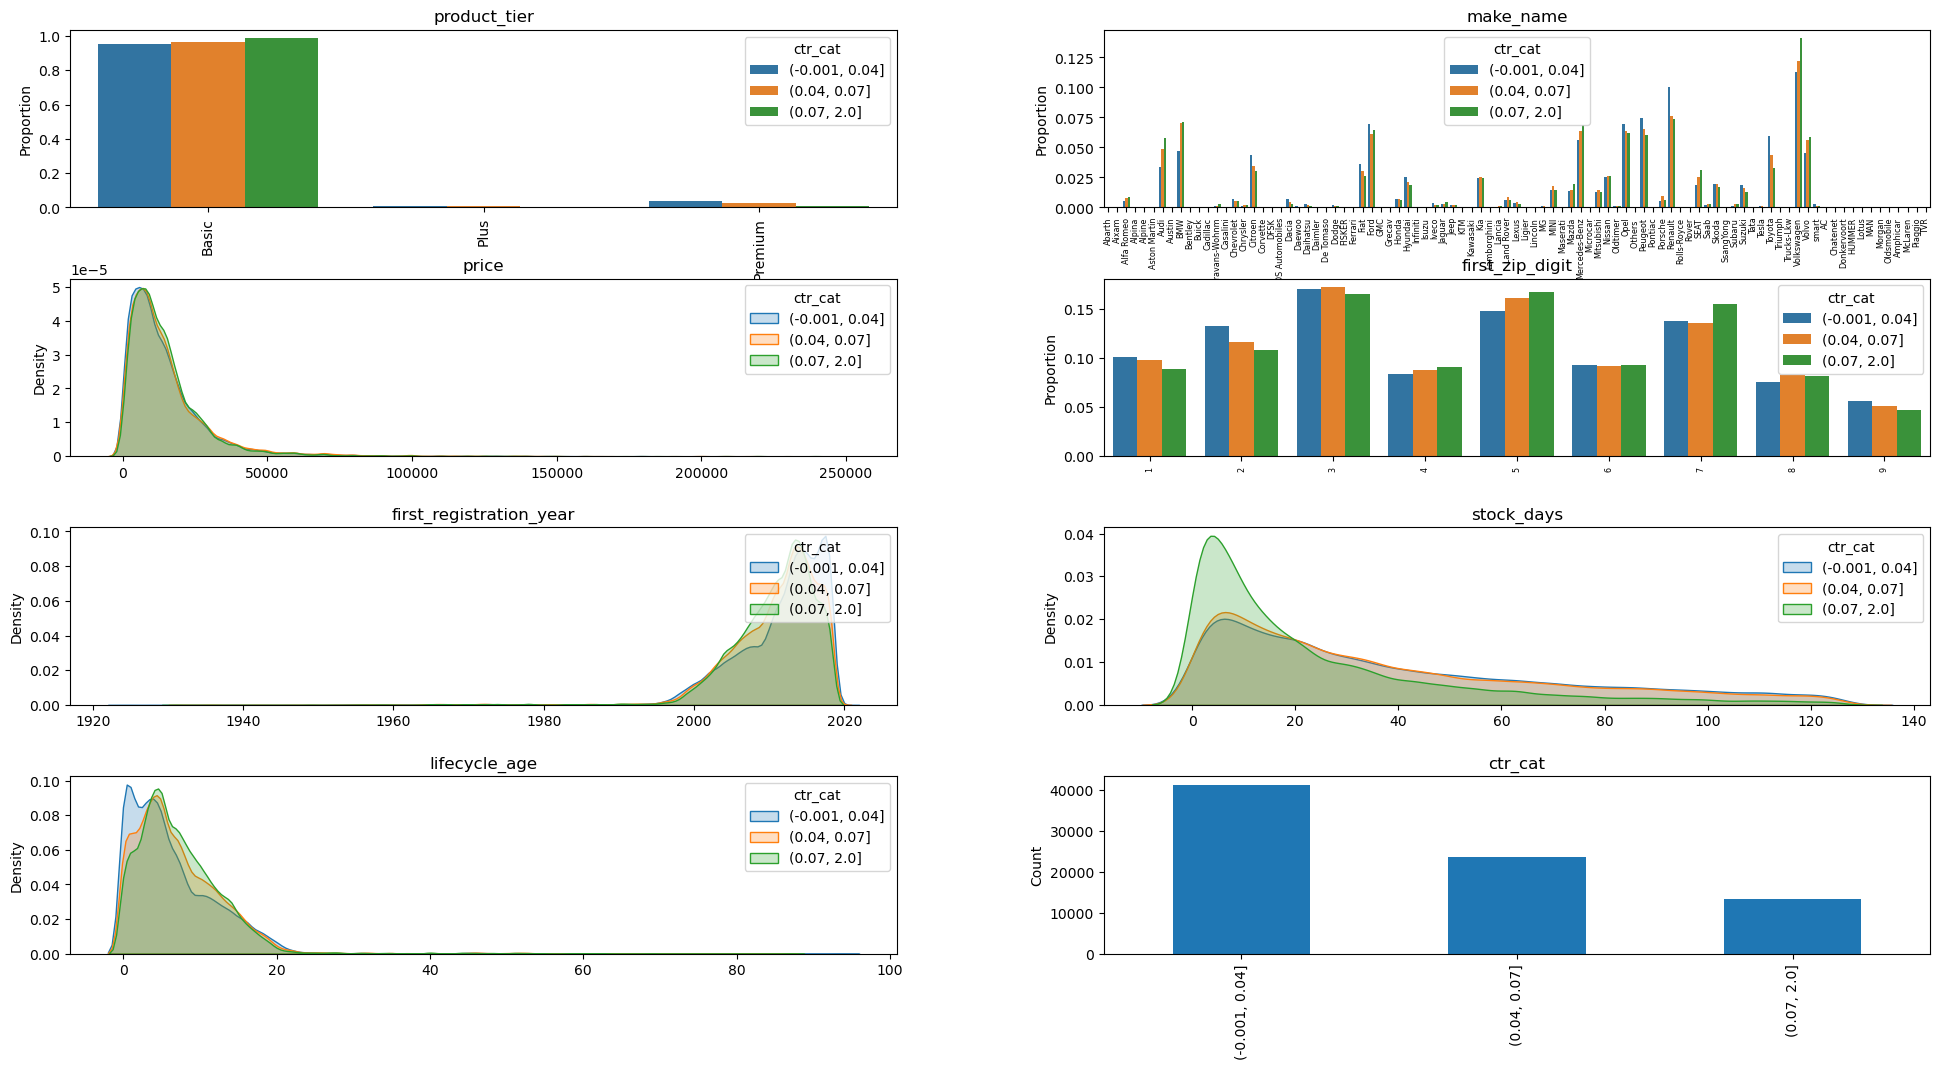

In [19]:
plot_describe(df, df.drop(columns=['article_id', 'created_date', 'deleted_date', 'ctr', 'detail_views_cat', 'detail_views', 'search_views']).columns, 
              log_dict={
                  'search_views': True,
                  'detail_views': True
              },
              hue='ctr_cat', ncols=2)

Findings:
- from a pure visual and bivariate inspection it does not seem that the features show a high discriminatory power in distinguishing product's with different click through rate classes because the feature distributions across the three classes look quite similar.

In the following, we train commonly used ML/DL regression models for the purpose of testing whether the number of times users view the details of product can be predicted. Our setup is as follows:
- since it could also be (and possibly even more) interesting to predict the click-through rate we train two models <br>
  (1) one to predict `detail_views` (exclude `ctr` from feature set as it is calculated from `detail_views`)<br>
  (2) the other to predict `ctr` (exclude `search_views` and `detail_views` from feature set since they are used to calculate `ctr`)<br>
- we aim at approximating the best set of hyperparameters on validation sets using cross-validation in order to prevent overfitting.
- since the target variable is a count variable that follows a Poisson distribution, we prefer models that can be tuned on minimizing Poisson deviance. Poisson deviance specifically compares the observed counts with the predicted counts and is thus most suited for this use case.
- since the target variable is a count variable we aim a minimizing the possion deviance which specifically compares the observed counts with the predicted counts based on the model. Minimizing the deviance helps ensure that the model captures the underlying patterns and variability in the count data.s. consequentlycwe evaluate the model performance on thei mean Poisson deviance and ng age mean absolute error (MAE) and benchmark agai of a random predictidrawn from a calibrated Poisson distribution.on 
- for scale sensitive models we scale the features by subtracting their mean and dividing by their standard deviation.

In [94]:
# Features
X = df.drop(columns=['article_id', 'detail_views', 'created_date', 'deleted_date', 'first_registration_year', 'ctr', 'detail_views_cat', 'ctr_cat'])
# One-hot encoding of make_name and product_tier
X = pd.get_dummies(X, columns=['product_tier'], drop_first=True, dtype=np.float32) # car make 'AC' serves as reference group
X = pd.get_dummies(X, columns=['make_name'], drop_first=True, dtype=np.float32)    # product tier 'Basic' serves as reference group
X = X.astype(np.float32)                                                           # create common dtype to ease matrix manipulation

# Target
y = df['detail_views']

In [95]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

In [96]:
# Drop features that are not available for ctr prediction
X_train_ctr = X_train.drop(columns=['search_views'])
X_test_ctr = X_test.drop(columns=['search_views'])

# ctr Target
y_train_ctr = df['ctr'].loc[y_train.index]
y_test_ctr = df['ctr'].loc[y_test.index]

In [98]:
NNRegressor = NeuralNetRegressor(
    RegressorModule,
    max_epochs=20,
    lr=0.1,
    device='cuda',
    train_split=False,   # disable the skorch-internal train-validation split as GridSearchCV conducts the train-validation splits
    verbose=0,           # Verbosity is steered via GridSearchCV
)

In [99]:
score_mae = make_scorer(mean_absolute_error, greater_is_better=False)
score_deviance = make_scorer(mean_poisson_deviance, greater_is_better=False)
scoring = {'MAE': score_mae, 'Poisson_deviance': score_deviance}

# Define the pipeline for each model
pipelines = [
        ('poisson_regression', Pipeline([
            ('model', PoissonRegressor(                              
                max_iter=600,
                solver='newton-cholesky'))                 
             ])),
    ('random_forest', Pipeline([
        ('model', RandomForestRegressor(random_state=333))
    ])),
        ('gradient_boosting', Pipeline([
            ('scaler', StandardScaler()),
            ('model', HistGradientBoostingRegressor(
                loss='poisson',                         # Poisson deviance as loss function
                random_state=333))     
        ])),
        ('neural_network', Pipeline([
            ('scaler', StandardScaler()),
            ('model', NNRegressor)
        ])),
    ]

# Define the hyperparameter grid for each model
hyperparameters = {
    'poisson_regression': { 
        'model__alpha': [0.1, 1, 10],
        'model__warm_start': [True, False]
    },
    'random_forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 2, 5],
        'model__min_samples_leaf': [1, 2, 5]
    },
    'gradient_boosting': {
        'model__max_iter': [100, 200, 300],
        'model__learning_rate': [0.01, 0,1, 0.5],
        'model__max_depth': [None, 2, 4]
    },
    'neural_network': {
        'model__lr': [0.05, 0.1],
        'model__module__num_units': [10, 20, 30]
    },
}

In [103]:
now = datetime.datetime.now().strftime("%d-%m-%y_%H%M%S")
with open(f'df_model_prediction_{now}.csv', 'w') as csvFile:
    fieldnames = ['MODEL', 'TARGET', 'PARAMS', 'MEAN_SCORE']
    writer = csv.DictWriter(csvFile, fieldnames=fieldnames)
    writer.writeheader()
    for model_name, pipeline in tqdm(pipelines):
        if model_name=='neural_network':
            n_jobs=None
        else:
            n_jobs=-1
        for strategy, (X, y) in [('detail_views', (X_train, y_train)), 
                                 ('ctr', (X_train_ctr, y_train_ctr)), 
                                 ]:
            grid_search = GridSearchCV(pipeline, hyperparameters.get(model_name), cv=3, scoring=scoring, refit='Poisson_deviance', verbose=2, n_jobs=n_jobs)
            if model_name=='neural_network':
                X = X.to_numpy()      
                # Handle the case where where ctr is predicted with one feature less
                # Check the second dimension of X
                second_dim = X.shape[1]
                # Check if the second dimension is smaller than original feature space
                if second_dim < 97:
                    # Calculate the number of zeros to add
                    num_zeros = 97 - second_dim
                    # Pad X with zeros along the second dimension
                    X = np.pad(X, ((0, 0), (0, num_zeros)), mode='constant')
                y = y.astype(np.float32).to_numpy()   
            grid_search.fit(X, y)
            score = grid_search.cv_results_['mean_test_MAE']*-1
            params = grid_search.cv_results_['params']
            for i in range(score.shape[0]):
                writer.writerow({
                'MODEL': model_name, 
                'TARGET': strategy,
                'PARAMS': params[i], 
                'MEAN_SCORE': score[i]    
                })
                csvFile.flush()

  0%|                                                   | 0/4 [00:00<?, ?it/s]

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


 25%|██████████▊                                | 1/4 [00:04<00:14,  4.98s/it]

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ...........model__alpha=0.1, model__warm_start=True; total time=   1.3s
[CV] END ............model__alpha=10, model__warm_start=True; total time=   1.3s
[CV] END ..........model__alpha=0.1, model__warm_start=False; total time=   1.1s
[CV] END ............model__alpha=10, model__warm_start=True; total time=   1.0s
[CV] END ...........model__alpha=0.1, model__warm_start=True; total time=   1.0s
[CV] END .............model__alpha=1, model__warm_start=True; total time=   1.1s
[CV] END ...........model__alpha=10, model__warm_start=False; total time=   0.6s
[CV] END .............model__alpha=1, model__warm_start=True; total time=   1.1s
[CV] END ............model__alpha=10, model__warm_start=True; total time=   1.0s
[CV] END ...........model__alpha=0.1, model__warm_start=True; total time=   0.4s
[CV] END .............model__alpha=1, model__warm_start=True; total time=   0.4s
[CV] END ...........model__alpha=10, model__warm

/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..........model__alpha=0.1, model__warm_start=False; total time=   1.2s
[CV] END ............model__alpha=10, model__warm_start=True; total time=   1.4s
[CV] END ..........model__alpha=0.1, model__warm_start=False; total time=   1.0s
[CV] END ............model__alpha=1, model__warm_start=False; total time=   1.1s
[CV] END ...........model__alpha=10, model__warm_start=False; total time=   0.5s
[CV] END .............model__alpha=1, model__warm_start=True; total time=   1.2s
[CV] END ............model__alpha=10, model__warm_start=True; total time=   1.0s
[CV] END ..........model__alpha=0.1, model__warm_start=False; total time=   1.1s
[CV] END ............model__alpha=10, model__warm_start=True; total time=   1.1s
[CV] END ..........model__alpha=0.1, model__warm_start=False; total time=   0.5s
[CV] END ............model__alpha=10, model__warm_start=True; total time=   0.4s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=100; total time=  38.1s
[CV] E

 50%|█████████████████████                     | 2/4 [13:17<15:37, 468.52s/it]

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/_loss/link.py:175: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
27 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/juliandoerr/anaconda3/envs/coding_ch

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ........model__lr=0.05, model__module__num_units=10; total time=  13.5s
[CV] END ........model__lr=0.05, model__module__num_units=10; total time=  11.2s
[CV] END ........model__lr=0.05, model__module__num_units=10; total time=  12.5s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END ........model__lr=0.05, model__module__num_units=20; total time=  13.0s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END ........model__lr=0.05, model__module__num_units=20; total time=  13.9s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END ........model__lr=0.05, model__module__num_units=20; total time=  12.1s
[CV] END ........model__lr=0.05, model__module__num_units=30; total time=  11.6s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END ........model__lr=0.05, model__module__num_units=30; total time=  11.2s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END ........model__lr=0.05, model__module__num_units=30; total time=  11.4s
[CV] END .........model__lr=0.1, model__module__num_units=10; total time=  11.6s
[CV] END .........model__lr=0.1, model__module__num_units=10; total time=  11.5s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END .........model__lr=0.1, model__module__num_units=10; total time=  11.5s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END .........model__lr=0.1, model__module__num_units=20; total time=  12.7s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END .........model__lr=0.1, model__module__num_units=20; total time=  11.8s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END .........model__lr=0.1, model__module__num_units=20; total time=  11.8s
[CV] END .........model__lr=0.1, model__module__num_units=30; total time=  12.9s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_tr

[CV] END .........model__lr=0.1, model__module__num_units=30; total time=  12.8s
[CV] END .........model__lr=0.1, model__module__num_units=30; total time=  11.9s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-95.54121653          nan          nan          nan          nan
          nan]
  warnings.warn(
/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-185.12862142           nan           nan           nan           nan
           nan]
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END ........model__lr=0.05, model__module__num_units=10; total time=  12.0s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END ........model__lr=0.05, model__module__num_units=10; total time=  11.7s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END ........model__lr=0.05, model__module__num_units=10; total time=  12.2s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END ........model__lr=0.05, model__module__num_units=20; total time=  11.7s
[CV] END ........model__lr=0.05, model__module__num_units=20; total time=  11.7s
[CV] END ..........model__alpha=0.1, model__warm_start=False; total time=   1.0s
[CV] END ............model__alpha=1, model__warm_start=False; total time=   1.2s
[CV] END ...........model__alpha=0.1, model__warm_start=True; total time=   1.0s
[CV] END ............model__alpha=1, model__warm_start=False; total time=   1.1s
[CV] END ...........model__alpha=0.1, model__warm_start=True; total time=   1.1s
[CV] END ............model__alpha=10, model__warm_start=True; total time=   1.1s
[CV] END ..........model__alpha=0.1, model__warm_start=False; total time=   1.0s
[CV] END ............model__alpha=1, model__warm_start=False; total time=   1.2s
[CV] END ...........model__alpha=0.1, model__warm_start=True; total time=   0.5s
[CV] END ............model__alpha=1, model__warm_start=False; total time=   0.4s
[CV] END ...........model__a

/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END ........model__lr=0.05, model__module__num_units=20; total time=  13.2s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END ........model__lr=0.05, model__module__num_units=30; total time=  12.1s
[CV] END ........model__lr=0.05, model__module__num_units=30; total time=  12.3s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END ........model__lr=0.05, model__module__num_units=30; total time=  12.3s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END .........model__lr=0.1, model__module__num_units=10; total time=  12.1s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END .........model__lr=0.1, model__module__num_units=10; total time=  12.5s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END .........model__lr=0.1, model__module__num_units=10; total time=  12.2s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END .........model__lr=0.1, model__module__num_units=20; total time=  12.9s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END .........model__lr=0.1, model__module__num_units=20; total time=  12.5s
[CV] END .........model__lr=0.1, model__module__num_units=20; total time=  12.6s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END .........model__lr=0.1, model__module__num_units=30; total time=  12.5s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END .........model__lr=0.1, model__module__num_units=30; total time=  12.3s


/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juliandoerr/anaconda3/envs/coding_challenge/lib/python3.11/site-packages/sklearn/metrics/_regression.py", line 1127, in mean_poisson_deviance
    return me

[CV] END .........model__lr=0.1, model__module__num_units=30; total time=  12.7s


100%|██████████████████████████████████████████| 4/4 [22:30<00:00, 337.67s/it]


For each model look at the best performing specification for both target variables.

In [105]:
df_model = pd.read_csv('df_model_prediction_30-04-24_230255.csv')

In [107]:
df_model.sort_values('MEAN_SCORE', ascending=True).groupby(['MODEL', 'TARGET']).head(1).sort_values(['MODEL', 'MEAN_SCORE'], ascending=False).style

,MODEL,TARGET,PARAMS,MEAN_SCORE
20,random_forest,detail_views,"{'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}",38.682649
47,random_forest,ctr,"{'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}",0.023759
1,poisson_regression,detail_views,"{'model__alpha': 0.1, 'model__warm_start': False}",432.768009
6,poisson_regression,ctr,"{'model__alpha': 0.1, 'model__warm_start': True}",0.024536
138,neural_network,detail_views,"{'model__lr': 0.05, 'model__module__num_units': 10}",95.541217
149,neural_network,ctr,"{'model__lr': 0.1, 'model__module__num_units': 30}",0.024107
68,gradient_boosting,detail_views,"{'model__learning_rate': 0.01, 'model__max_depth': None, 'model__max_iter': 300}",40.139709
132,gradient_boosting,ctr,"{'model__learning_rate': 0.5, 'model__max_depth': 2, 'model__max_iter': 100}",0.023453


In [120]:
md(f"""The best performing model is a {df_model.loc[df_model.TARGET=='detail_views'].sort_values('MEAN_SCORE', ascending=True).iloc[0].MODEL}/{df_model.loc[df_model.TARGET=='ctr'].sort_values('MEAN_SCORE', ascending=True).iloc[0].MODEL}
with an MAE of {round(df_model.loc[df_model.TARGET=='detail_views'].sort_values('MEAN_SCORE', ascending=True).iloc[0].MEAN_SCORE)}/{round(df_model.loc[df_model.TARGET=='ctr'].sort_values('MEAN_SCORE', ascending=True).iloc[0].MEAN_SCORE*100, 3)}  views/percentage points
on the validation folds for the task of predicting the number of user clicks on an article/the click through rate. Let's see how well the model performs on the hold-out test data.""")

The best performing model is a random_forest/gradient_boosting
with an MAE of 39/2.345  views/percentage points
on the validation folds for the task of predicting the number of user clicks on an article/the click through rate. Let's see how well the model performs on the hold-out test data.

In [137]:
# Define the best performing model for detail_views prediction
pipeline = Pipeline(steps=[
    ('best_model', RandomForestRegressor(max_depth=None, min_samples_leaf=5, n_estimators=300, n_jobs=-1, random_state=333))
])

# Train on the entire detail_views feature set
pipeline.fit(X_train, y_train)

# Make predictions for the test observations
y_pred = pipeline.predict(X_test)

# Return performance metrics
md(f"""The best performing model makes an out-of-sample a prediction error of {round(mean_absolute_error(y_test, y_pred))} views. This means that on average the model under-/overestimates the number of detail views by 37 views.""")

The best performing model makes an out-of-sample a prediction error of 37 views. This means that on average the model under-/overestimates the number of detail views by 37 views.

In [140]:
# Define the best performing model for ctr prediction
pipeline = Pipeline(steps=[
    ('best_model', HistGradientBoostingRegressor(learning_rate= 0.5, max_depth=2, max_iter=100, loss='poisson', random_state=333))
])

# Train on the entire ctr feature set
pipeline.fit(X_train_ctr, y_train_ctr)

# Make predictions for the test observations
y_pred = pipeline.predict(X_test_ctr)

# Return performance metrics
md(f"""The best performing model's out-of-sample a prediction error is {round(mean_absolute_error(y_test_ctr, y_pred), 3)}. This means that on average the model under-/overestimates the article's click through rate by 2.3 percentage points.""")

The best performing model's out-of-sample a prediction error is 0.023. This means that on average the model under-/overestimates the article's click through rate by 2.3 percentage points.

Both models seem to generalize well. In order to judge how well the models perform, i.e. how severe their error is, we compare the models' error against the error a simple mean predictor would do.

In [144]:
# Error of naive predictor for detail_views
md(f"""Prediction error mean predictor: {round(mean_absolute_error(y_test, np.repeat(y_train.mean(), len(y_test))))} views""")

Prediction error mean predictor: 94 views

In [148]:
# Error of naive predictor for ctr
md(f"""Prediction error mean predictor: {round(mean_absolute_error(y_test_ctr, np.repeat(y_train_ctr.mean(), len(y_test_ctr)))*100,3)} percentage points""")

Prediction error mean predictor: 2.455 percentage points

**This means that the prediction of the number of detail views works decently enough based on information about the product and possibly information on remarketing campains **

These results come with many caveats:
- zero knowledge about the actual business case, i.e. no exchange with business unit, no information on the meaning/logic of different product tier classes
- limited knowledge about the features and about which features from a process perspective are available at inference
- results derived under time constraints

In a real-world scenario I would undergo the following next steps:
- get in close exchange with business unit trying to better understand the actual use case and the meaning/logic of the target variable `product_tier`
- gather additional observations and/or features if possible
- spend more time on understanding/engineering features
- implement further approaches to handle imbalanced data